# Cloud clustering - examples and description of the Radial Distribution Function (RDF)

The aim of this notebook is to show examples of cloud clustering and describe how clustering can be objectively measured using the radial distribution function. 

The radial distribution function measures the clustering of objects as a function of distance. It is commonly used in statistical mechanics to describe how the density of particles varies as a function of distance from a reference particle. See https://en.wikipedia.org/wiki/Radial_distribution_function

As an example let us load a typical cloud field.

##### Some ideas for future features
- Pick two or three different fields (different organization)
- Also look at vertical velocity and impact of separation (is it quite as large?)
- Use ensemble_tools package
- Look at other clustering metrics such as SCAI
- Highlight eye detection of organization


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


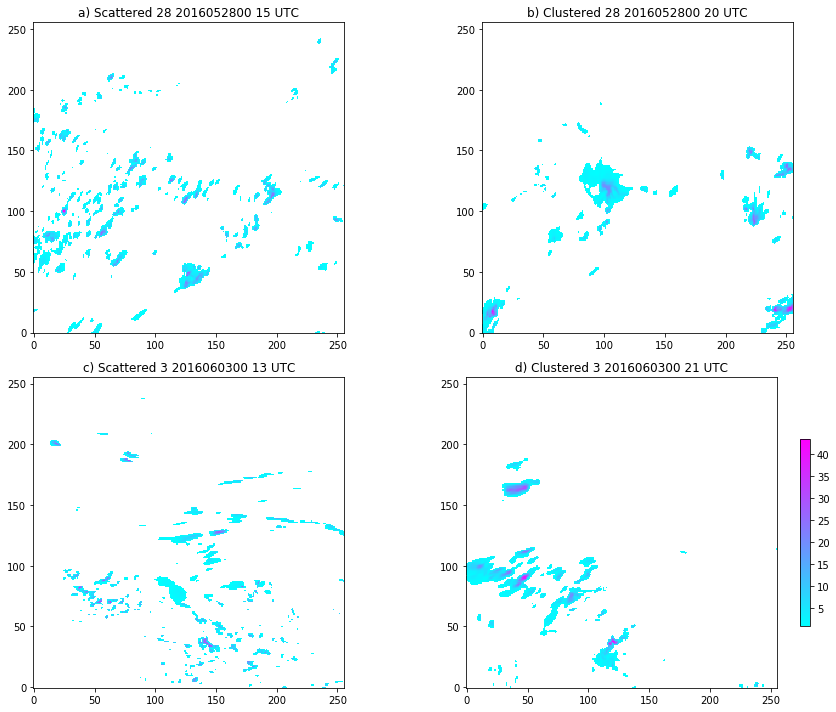

In [13]:
# Import modules and load fields
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../python_scripts')
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cosmo_utils.pyncdf import getfobj_ncdf   # This is a module developed specifically for COSMO output

# Pick 4 examples
plims = (50, -51, 50, -51)   # Limits for plotting area
dates = ['2016052800', '2016052800', '2016060300', '2016060300']
times = [15, 20, 13, 21]
tags = ['a) Scattered 28', 'b) Clustered 28', 'c) Scattered 3', 'd) Clustered 3']
fig, axmat = plt.subplots(2, 2, figsize = (13, 10))
cm_prec = plt.cm.cool
cm_prec.set_under(color = 'white')
prec_fields = []
for d, t, tag, ax in zip(dates, times, tags, np.ravel(axmat)):
    fn = ('/project/meteo/scratch-old/users/stephan.rasp/convective_variability_data/raw_data/' + 
          d + '/deout_ceu_pspens/det/OUTPUT/lfff00' + str(t).zfill(2) + '0000.nc_30m_surf')
    prec_field = getfobj_ncdf(fn, 'PREC_ACCUM').data
    prec_fields.append(prec_field)
    im = ax.imshow(prec_field[plims[0]:plims[1], plims[2]:plims[3]], cmap=cm_prec, origin='lower', vmin=1)
    ax.set_title(tag + ' ' + d + ' ' + str(t).zfill(2) + ' UTC')
fig.colorbar(im, shrink = 0.6)
plt.tight_layout()

With our human eyes and brains we would say that ??? is clearly more "clustered" than ???. But how can we get an objective metric for clustering? We will chose one of the fields above (???) and go through the methodology step by step.

The first step is to create a binary field using a threshold. For precipitation we are using a threshold of 1 mm/h. Then we can identify continuous objects as grid points which share a common border. Inspiration on how to do this in Python comes from this great example: https://dragly.org/2013/03/25/working-with-percolation-clusters-in-python/

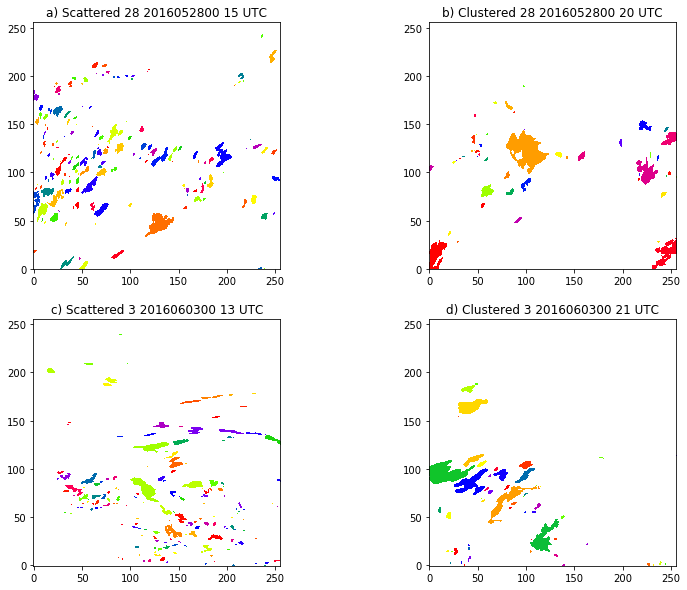

In [14]:
import helpers

threshold = 1.
labels_list = []
fig, axmat = plt.subplots(2, 2, figsize = (13, 10))
cm_prism = plt.cm.prism
cm_prism.set_under(color = 'white')
for pr, d, t, tag, ax in zip(prec_fields, dates, times, tags, np.ravel(axmat)):
    labels = helpers.identify_clouds(pr, threshold, water=False)[0]
    labels_list.append(labels)
    ax.imshow(labels[plims[0]:plims[1], plims[2]:plims[3]], cmap=cm_prism, origin='lower', vmin = 1)
    ax.set_title(tag + ' ' + d + ' ' + str(t).zfill(2) + ' UTC')



Each identified "object" is now shown with a different color. We can see that many of the objects are rather large and seem to contain more than one "cloud". 

### Cloud separation
To separate the large objects into smaller sub-objects we can use a local maximum filter. This filter identifies the local maxima for each object. From these maxima a watershed algorithm is used to define the extent of each sub-object. The switch in the identify_clouds function is called water.

There is one tuning parameter called **neighborhood**. This is a 2D array, which defines how large the search perimeter for the local maximum search algorithm is. The smaller the array, the closer the individual maxima can be toghether. So a very small perimeter gives many very small clouds. For now we pick 5 grid points, which is the effective resolution of the model.

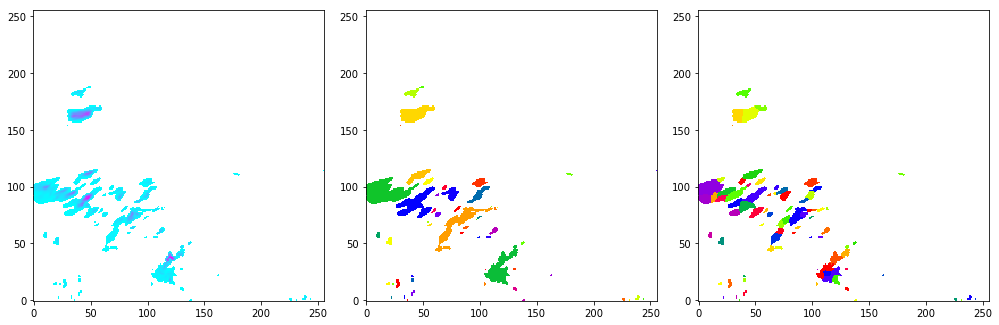

In [21]:
neighborhood = np.ones((5,5))
reload(helpers)

labels_sep_list = []
for pr in prec_fields:
    labels_sep_list.append(helpers.identify_clouds(pr, threshold, water=True, neighborhood = neighborhood)[0])
    
fig, axarr = plt.subplots(1, 3, figsize=(14, 5))
axarr[0].imshow(prec_fields[3][plims[0]:plims[1], plims[2]:plims[3]], cmap=cm_prec, origin='lower', vmin = 1)
axarr[1].imshow(labels_list[3][plims[0]:plims[1], plims[2]:plims[3]], cmap=cm_prism, origin='lower', vmin = 1)
axarr[2].imshow(labels_sep_list[3][plims[0]:plims[1], plims[2]:plims[3]], cmap=cm_prism, origin='lower', vmin = 1)
plt.tight_layout()

As you can see, the cloud separation algorithm separates the clouds very agressively. (This is an extreme example!) It certainly seems like some of the separated cloud objects are too small. The unseparated cloud objects, on the other, hand appear to be too large. Some tuning of the threshold could potentially yield better results, but the choice will always remain ambiguous. The important lesson to keep in mind is to always compare both methods, separated and non-separated clouds, and check the results for consistency. 

Now that we have identified our clouds, we can finally use the radial distribution function and get a measure for clustering.

## Computing the RDF
The first step to compute the RDF is compute the centers of mass of each identified object. This is already done inside the calc_rdf() function. 

Then we have to define some parameters:

1. The maximum search radius **r_max**
2. The bin size **dr**

### Mathematical formulation
We are computing a discrete version of the RDF in 2D.

The normalized RDF $g(r)$ is given by
$$g(r) = \frac{\langle N (r \pm 0.5 \Delta r) \rangle}{A (r \pm 0.5 \Delta r)} \frac{1}{\rho} $$
where $N (r \pm 0.5 \Delta r)$ is the number of objects in the interval $r \pm 0.5 \Delta r$ and the angled brackets indicate the ensemble mean over all objects. $A (r \pm 0.5 \Delta r)$ is the area of the annulus, which is given by $2 \pi r \Delta r$. $\rho$ is the domain mean object density. 

The RDF which is normalized by the domain mean density is therefore unitless and gives the following information: "How much more likely is an object located within a distance interval $[r - \Delta r, r + \Delta r]$ to another object, compared to a completely random distribution of objects in the domain?" A completely random distribution, therefore, has a value of 1 at all radii.

#### Non-normalized version
It can be insightful to also compute the non-normalized version of the RDF, which I will denote here as $n(r) = g(r) * \rho$. This metric then has units [objects per $m^2$] and can be interpreted as: "How many objects per unit area can be found within a distance interval $[r - \Delta r, r + \Delta r]$ to another object?" This metric can be advantageous when comparing RDFs with very different total densities $\rho$, depending on the research question. Note that the shape of the RDF curve remains the same, just the absolute value changes. Therefore the differences will only become apparent when comparing the absolute values of several RDF curves.

In total, we now have 4 different versions of the radial distribution function: separated and non-separated clouds times normalized and non-normalized RDF. Each metric has a slightly different meaning. For our examples, we will now look at all versions.

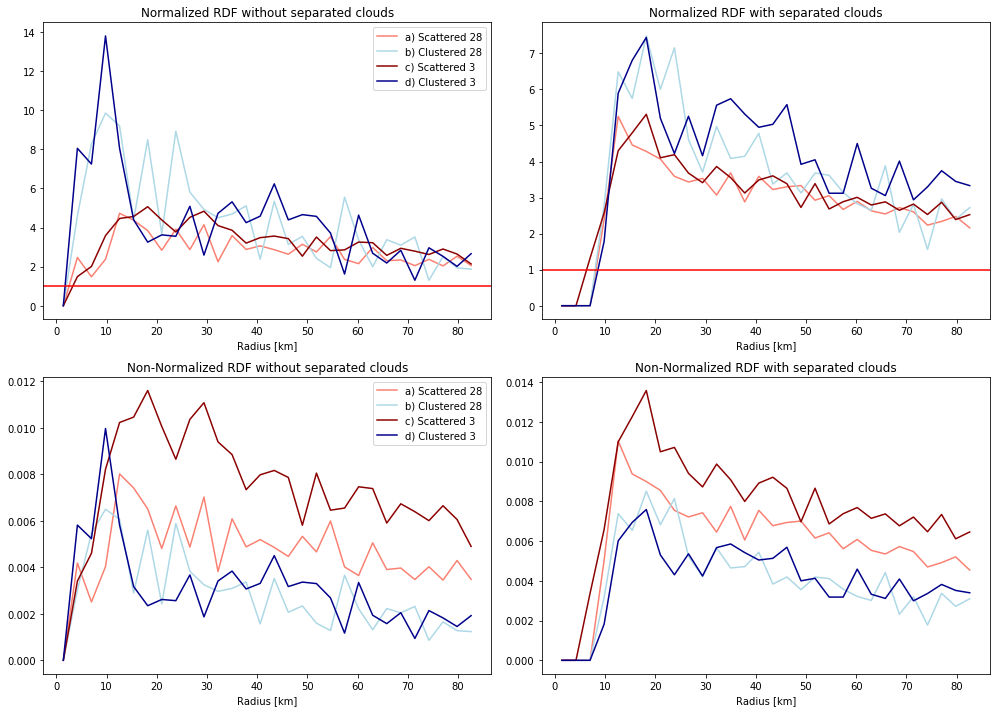

In [22]:
import sys
sys.path.append('../python_scripts')
from helpers import calc_rdf, pair_correlation_2d

r_max = 30   # In grid points
dr = 1       # Also in grid points

fig, axmat = plt.subplots(2, 2, figsize=(14, 10))
colors = ['salmon', 'lightblue', 'darkred', 'darkblue']
for labels, labels_sep, pr, tag, c in zip(labels_list, labels_sep_list, prec_fields, tags, colors):
    rdf, radii = calc_rdf(labels, pr, normalize=True, dx=2.8e3, r_max=r_max, dr=dr)
    axmat[0, 0].plot(radii / 1000., rdf, label=tag, c=c)
    
    rdf, radii = calc_rdf(labels_sep, pr, normalize=True, dx=2.8e3, r_max=r_max, dr=dr)
    axmat[0, 1].plot(radii / 1000., rdf, c=c)
    
    rdf, radii = calc_rdf(labels, pr, normalize=False, dx=2.8e3, r_max=r_max, dr=dr)
    axmat[1, 0].plot(radii / 1000., rdf, label=tag, c=c)
    
    rdf, radii = calc_rdf(labels_sep, pr, normalize=False, dx=2.8e3, r_max=r_max, dr=dr)
    axmat[1, 1].plot(radii / 1000., rdf, c=c)


axmat[0, 0].set_title('Normalized RDF without separated clouds')
axmat[0, 0].set_xlabel('Radius [km]')
axmat[0, 0].axhline(1, c='r')
axmat[0, 0].legend()

axmat[0, 1].set_title('Normalized RDF with separated clouds')
axmat[0, 1].set_xlabel('Radius [km]')
axmat[0, 1].axhline(1, c='r')

axmat[1, 0].set_title('Non-Normalized RDF without separated clouds')
axmat[1, 0].set_xlabel('Radius [km]')
axmat[1, 0].legend()

axmat[1, 1].set_title('Non-Normalized RDF with separated clouds')
axmat[1, 1].set_xlabel('Radius [km]')

plt.tight_layout()

We see that all four versions show different results. Therefore, some interpretation is needed. From our visual interpretation of the four scenes, we identified two scattered and two clustered situations. In the plots above, only the normalized versions show higher values for the clustered scenes. The non-normalized versions have similar or higher values for the scattered scenes. 

Recall that the normalization is done by dividing by the domain-mean object density. Therefore, these metric contain information on the clustering relative to the environment. If we go back to the first plot at the top of the page, it is easy to understand why we get these results. We identified our clustered scenes mainly because there were bigger, isolated blobs of precipitation. In fact, the absolute number of clouds in proximity to other clouds is higher in the scattered cases, simply because the clouds are smaller. This last bit of information is what the non-normalized versions measure. 

Therefore we can say that the normalized RDF comes closest to our visual intuition. That leaves the question of the cloud separation. Here we can see that for the scattered cases, the cloud separation doesn't change the results all that much. The maximum is slightly larger and shifted to smaller radii. For the clustered scened, on the other hand, the changes are quite drastic as the values are halved. It is important to note here that theses values are quite sensitive to the choice of the **neighborhood** parameter in the identify_clouds function. 

What to make of it all? The key message to take from this exercise is that there is no single metric which accurately measures clustering. Clustering can mean a number of things. Therefore, it is important to design a metric with a specific purpose in mind. Our purpose was to get an approximate metric which is in agreement with our visual interpretation. We do not intend to use the quantitative values any further. For this purpose the normalized RDF without cloud separation seems to be the best metric.

#### A note on the first bin
The first bin is necessarily always zero when using **dr** = $\Delta x$. Two clouds which are immediately touching must be one object!

#### How to handle boundaries?
There is two boundary situations.

1. Data is available in the entire analysis domain (for example, full model output)
2. Data is available only in part of the domain (for example, radar domain)

In both situations, only identified centers of mass are taken for the RDF computation where the entire circle of radius r_max is within the domain where data is available.